# EVs - modeling 

goal: model the impact of EVs on the grid

In [173]:
## Necessaries libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

## Metadata on EVs and their usage

## Estimate the evolution of numbers EVs in Switzerland and the technology

In [108]:
data = pd.read_csv('data/ev_data.csv', encoding='ISO-8859-1')
data["Canton"].unique()


array(['Switzerland', 'Zürich', 'Bern', 'Luzern', 'Uri', 'Schwyz',
       'Obwalden', 'Nidwalden', 'Glarus', 'Zug', 'Fribourg', 'Solothurn',
       'Basel-Stadt', 'Basel-Landschaft', 'Schaffhausen',
       'Appenzell-Ausserrhoden', 'Appenzell-Innerrhoden', 'Sankt Gallen',
       'Graubünden', 'Aargau', 'Thurgau', 'Ticino', 'Vaud', 'Valais',
       'Neuchâtel', 'Genève', 'Jura', 'Confederation'], dtype=object)

In [109]:
data.head()

,Canton,Vehicle group / type,Fuel,1990,1991,1992,1993,1994,1995,1996,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Switzerland,> Passenger cars,Petrol,2905762,2975154,3006666,3022762,3073062,3132238,3166299,...,3234560,3201710,3173806,3149902,3127023,3114726,3099442,3087390,3054773,2991092
1,Switzerland,> Passenger cars,Diesel,79129,81883,83640,85703,90747,95585,100412,...,1035843,1123676,1214075,1291500,1346938,1374246,1382645,1379077,1360111,1319337
2,Switzerland,> Passenger cars,Electricity,409,671,771,774,775,770,759,...,2683,4439,7531,10724,14539,19181,28716,43396,71697,110751
3,Switzerland,> Passenger cars,Other,97,90,151,284,458,583,623,...,47799,54665,62657,71903,82323,94535,113149,148472,222785,300100
4,Switzerland,> Passenger cars,Without motor,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [117]:
## Function to keep useful information from the data 

def process_data(df:  pd.core.frame.DataFrame)  -> pd.DataFrame:
    df = df[(df["Canton"] == "Switzerland") & (df["Vehicle group / type"] == "> Passenger cars")].drop(columns=['Canton', 'Vehicle group / type'])
    df.set_index('Fuel', inplace=True)
    df = df.T
    df.drop(columns=["Without motor"], inplace=True)
    df.rename(columns={'Other': 'hybrid', 'Electricity': 'battery_electric'}, inplace=True)
    df["total_car"] = df.sum(axis=1)
    df['Year'] = df.index
    df = df.reset_index(drop=True)
    return df


Fuel,Petrol,Diesel,battery_electric,hybrid,total_car,Year
0,2905762,79129,409,97,2985397,1990
1,2975154,81883,671,90,3057798,1991
2,3006666,83640,771,151,3091228,1992
3,3022762,85703,774,284,3109523,1993
4,3073062,90747,775,458,3165042,1994


In [254]:
data_ev = process_data(data)
data_ev.head()

Fuel,Petrol,Diesel,battery_electric,hybrid,total_car,Year
0,2905762,79129,409,97,2985397,1990
1,2975154,81883,671,90,3057798,1991
2,3006666,83640,771,151,3091228,1992
3,3022762,85703,774,284,3109523,1993
4,3073062,90747,775,458,3165042,1994


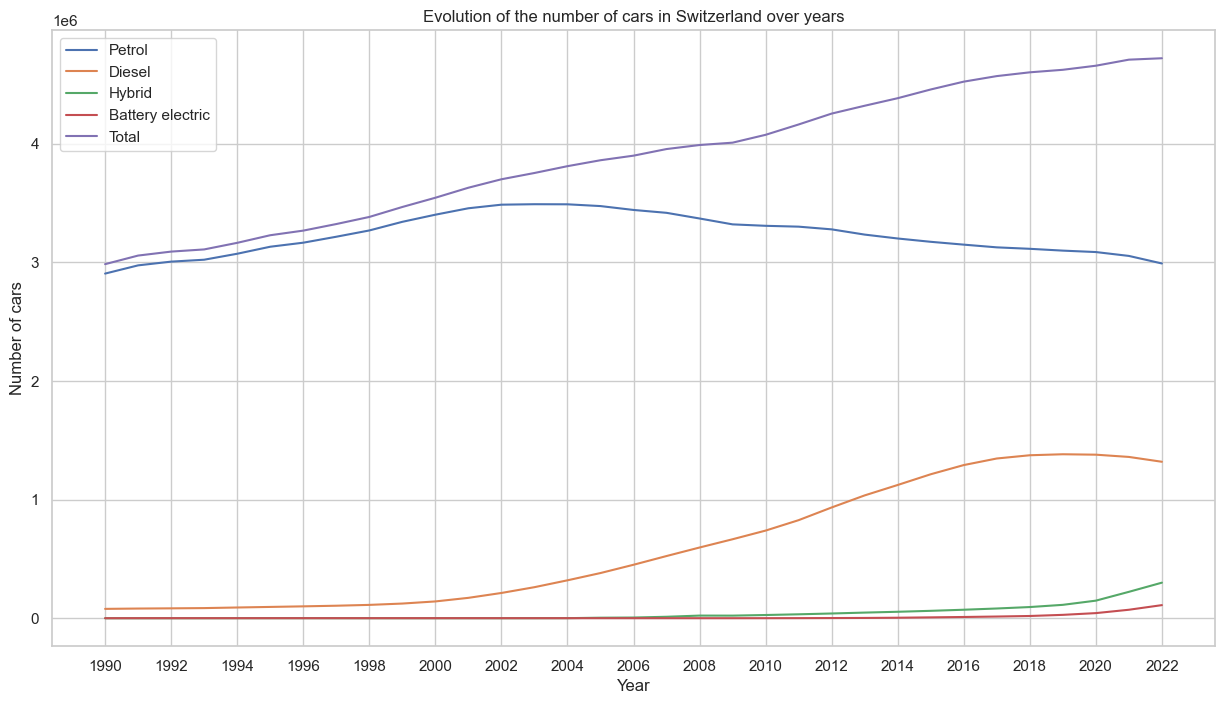

In [256]:
def plot_evolution(df: pd.core.frame.DataFrame) -> None:
    plt.figure(figsize=(15, 8))
    
    sns.lineplot(data=df, x='Year', y='Petrol', label='Petrol')
    sns.lineplot(data=df, x='Year', y='Diesel', label='Diesel')
    sns.lineplot(data=df, x='Year', y='hybrid', label='Hybrid')
    sns.lineplot(data=df, x='Year', y='battery_electric', label='Battery electric')
    sns.lineplot(data=df, x='Year', y='total_car', label='Total')
    
    # Set the x-ticks and labels for every 2 years
    x_ticks = df['Year'].unique()[::2]
    x_tick_labels = [str(year) for year in x_ticks]
    
    plt.xticks(ticks=x_ticks, labels=x_tick_labels)
    

    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Number of cars')
    plt.title('Evolution of the number of cars in Switzerland over years')
    plt.show()

# Assuming you have a DataFrame named data_ev
plot_evolution(data_ev)

In [ ]:
# Forecasting the number of cars in Switzerland with a plynomial regression model up to 2050

In [289]:
## Need to define the constraints of the polynomial regression model

intercept_year = 2050
Petrol_2050 = 0
Diesel_2050 = 0
hybrid_2050 = 1e6
battery_electric_2050 = 5e6
total_car_2050 = Petrol_2050 + Diesel_2050 + hybrid_2050 + battery_electric_2050
intercept_value = pd.DataFrame({"Year": intercept_year, "Petrol": Petrol_2050, "Diesel": Diesel_2050, "hybrid": hybrid_2050, "battery_electric": battery_electric_2050, "total_car": total_car_2050}, index=[0])


In [258]:
data_ev.tail()

Fuel,Petrol,Diesel,battery_electric,hybrid,total_car,Year
28,3114726,1374246,19181,94535,4602688,2018
29,3099442,1382645,28716,113149,4623952,2019
30,3087390,1379077,43396,148472,4658335,2020
31,3054773,1360111,71697,222785,4709366,2021
32,2991092,1319337,110751,300100,4721280,2022


In [290]:
data_ev = pd.concat([data_ev, intercept_value], ignore_index=True)

In [260]:
data_ev.tail()

,Petrol,Diesel,battery_electric,hybrid,total_car,Year
29,3099442,1382645,28716.0,113149.0,4623952.0,2019
30,3087390,1379077,43396.0,148472.0,4658335.0,2020
31,3054773,1360111,71697.0,222785.0,4709366.0,2021
32,2991092,1319337,110751.0,300100.0,4721280.0,2022
33,100000,0,5000000.0,1000000.0,6000000.0,2050


In [130]:
int(data_ev["Year"].max())

2022

In [296]:
degree = 10  # You can change this to a higher degree if needed

# Put more weight on the last years (where we observe greater changes)
weights = np.exp(np.linspace(-10, 0, len(data_ev)))

data_ev_forecast = pd.DataFrame({'Year': list(range(2023, 2050))})

# Create a loop to perform polynomial regression for each column
for col in data_ev.columns:
    if col == 'Year':
        continue  # Skip the 'Year' column
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(data_ev[['Year']])
    
    # Create a linear regression model
    model = LinearRegression()
    
    # Fit the model to the polynomial features for the current column
    model.fit(X_poly, data_ev[col], sample_weight=weights)
    
    # Forecast future values for each year from 2024 to 2050
    years_forecast = list(range(2023, 2050))
    future_years_poly = poly.transform(np.array(years_forecast).reshape(-1, 1))
    predictions = model.predict(future_years_poly)
    
    # Create a new column with the predicted values and add it to the DataFrame
    data_ev_forecast[col] = predictions

/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warni

In [297]:
data_ev_forecast.tail()

,Year,Petrol,Diesel,battery_electric,hybrid,total_car
22,2045,951055.619374,414743.311783,3.309908e+06,1.023707e+06,5.672567e+06
23,2046,786380.036698,335554.111283,3.610807e+06,1.028586e+06,5.731697e+06
24,2047,613459.762000,254319.432562,3.929688e+06,1.028946e+06,5.793812e+06
25,2048,432046.908603,171179.545988,4.267126e+06,1.024509e+06,5.859096e+06
26,2049,241891.365463,86276.240276,4.623701e+06,1.014997e+06,5.927736e+06


In [180]:

# Choose the degree of the polynomial
degree = 2  # You can change this to a higher degree if needed

# Define your constraint for the number of EV cars in 2050
desired_ev_cars_2050 = 1000  # Adjust this value as needed

# Create polynomial features
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(data_ev[['Year']])

# Create a linear regression model
model = LinearRegression()

# Define the objective function to minimize
def objective_function(coefficients):
    # Fit the model to the data with the given coefficients
    model.coef_ = coefficients
    model.fit(X_poly, data_ev['battery_electric'])
    
    # Predict the number of EV cars in 2050
    future_years_poly = poly.transform(np.array([2050]).reshape(-1, 1))
    prediction_2050 = model.predict(future_years_poly)
    
    # Define the constraint: ensure prediction_2050 >= desired_ev_cars_2050
    constraint = prediction_2050 - desired_ev_cars_2050
    
    # Return the squared constraint as the objective to minimize
    return constraint**2

# Initial coefficients (can be random)
initial_coefficients = np.ones(degree + 1)

# Perform the constrained optimization
result = minimize(objective_function, initial_coefficients)

# Get the optimized coefficients
optimized_coefficients = result.x

# Fit the model with the optimized coefficients
model.coef_ = optimized_coefficients
model.fit(X_poly, data_ev['battery_electric'])

# Make predictions for future years
future_years = list(range(2023, 2050))
future_years_poly = poly.transform(np.array(future_years).reshape(-1, 1))
predictions = model.predict(future_years_poly)

# Create a DataFrame to store the year and predicted number of cars
forecast_data = pd.DataFrame({'Year': future_years, 'Number_of_Cars': predictions})

# Print or save the forecast_data DataFrame
print(forecast_data)


    Year  Number_of_Cars
0   2023    67527.043983
1   2024    74752.929418
2   2025    82308.182658
3   2026    90192.803702
4   2027    98406.792550
5   2028   106950.149203
6   2029   115822.873659
7   2030   125024.965919
8   2031   134556.425984
9   2032   144417.253853
10  2033   154607.449526
11  2034   165127.013003
12  2035   175975.944284
13  2036   187154.243369
14  2037   198661.910259
15  2038   210498.944952
16  2039   222665.347450
17  2040   235161.117752
18  2041   247986.255858
19  2042   261140.761768
20  2043   274624.635482
21  2044   288437.877000
22  2045   302580.486323
23  2046   317052.463449
24  2047   331853.808380
25  2048   346984.521115
26  2049   362444.601654


/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warni

In [298]:
weights

array([4.53999298e-05, 6.09240621e-05, 8.17565437e-05, 1.09712521e-04,
       1.47227815e-04, 1.97571154e-04, 2.65128984e-04, 3.55787658e-04,
       4.77446320e-04, 6.40705159e-04, 8.59789016e-04, 1.15378679e-03,
       1.54831469e-03, 2.07774816e-03, 2.78821704e-03, 3.74162491e-03,
       5.02104275e-03, 6.73794700e-03, 9.04193252e-03, 1.21337469e-02,
       1.62827818e-02, 2.18505451e-02, 2.93221591e-02, 3.93486301e-02,
       5.28035703e-02, 7.08593166e-02, 9.50890768e-02, 1.27604004e-01,
       1.71237143e-01, 2.29790275e-01, 3.08365168e-01, 4.13808099e-01,
       5.55306373e-01, 7.45188817e-01, 1.00000000e+00])

In [299]:
concatenated_data_ev = pd.concat([data_ev, data_ev_forecast], ignore_index=True)
concatenated_data_ev = concatenated_data_ev.astype({'Year': str})
concatenated_data_ev.tail()

,Petrol,Diesel,battery_electric,hybrid,total_car,Year
57,951055.619374,414743.311783,3.309908e+06,1.023707e+06,5.672567e+06,2045
58,786380.036698,335554.111283,3.610807e+06,1.028586e+06,5.731697e+06,2046
59,613459.762000,254319.432562,3.929688e+06,1.028946e+06,5.793812e+06,2047
60,432046.908603,171179.545988,4.267126e+06,1.024509e+06,5.859096e+06,2048
61,241891.365463,86276.240276,4.623701e+06,1.014997e+06,5.927736e+06,2049


In [300]:
# order concatenated_data_ev by year
concatenated_data_ev = concatenated_data_ev.sort_values(by=['Year'])
concatenated_data_ev.tail()

,Petrol,Diesel,battery_electric,hybrid,total_car,Year
59,613459.762000,254319.432562,3.929688e+06,1.028946e+06,5.793812e+06,2047
60,432046.908603,171179.545988,4.267126e+06,1.024509e+06,5.859096e+06,2048
61,241891.365463,86276.240276,4.623701e+06,1.014997e+06,5.927736e+06,2049
34,0.000000,0.000000,5.000000e+06,1.000000e+06,6.000000e+06,2050
33,100000.000000,0.000000,5.000000e+06,1.000000e+06,6.000000e+06,2050


In [285]:
concatenated_data_ev[concatenated_data_ev["Year"] >= "2022"].head()

,Petrol,Diesel,battery_electric,hybrid,total_car,Year
32,2.991092e+06,1.319337e+06,110751.000000,300100.000000,4.721280e+06,2022
34,2.963031e+06,1.370556e+06,140771.698982,301623.688412,4.775294e+06,2023
35,2.921605e+06,1.367607e+06,182311.406258,341366.999569,4.811673e+06,2024
36,2.876871e+06,1.359883e+06,230601.228096,381980.582088,4.847452e+06,2025
37,2.828633e+06,1.347514e+06,286100.945503,423236.103390,4.882785e+06,2026


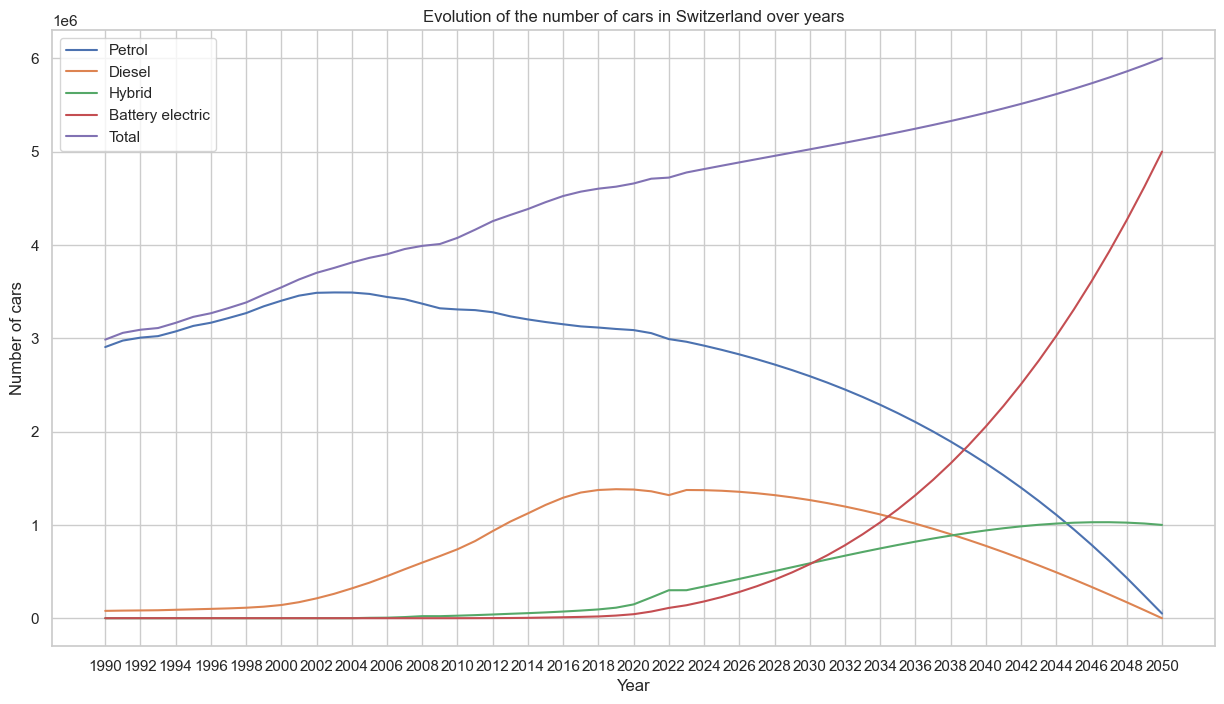

In [301]:
plot_evolution(concatenated_data_ev)

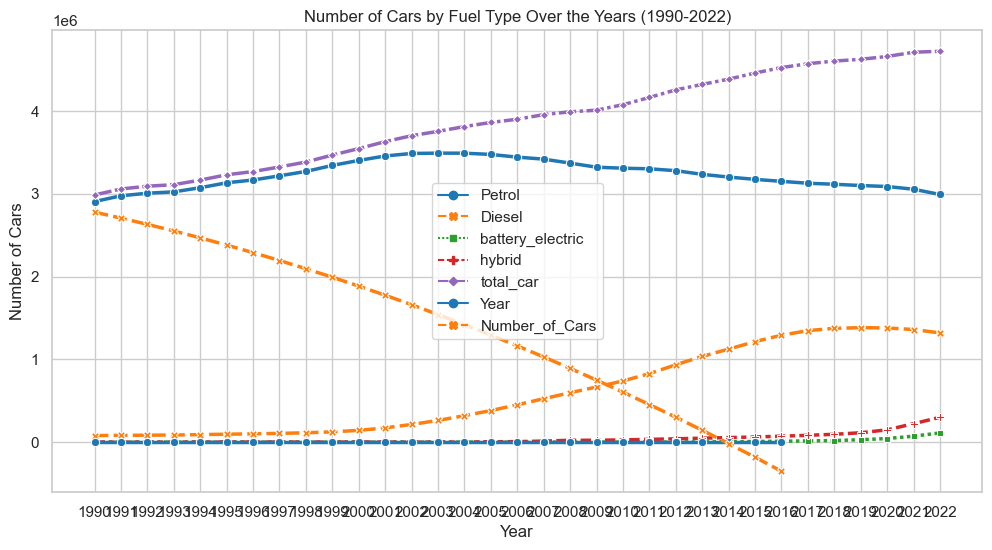

In [104]:
## plot number of cars for petrol
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, markers=True, palette="tab10", linewidth=2.5)
sns.lineplot(data=forecast_data, markers=True, palette="tab10", linewidth=2.5)
plt.xlabel('Year')
plt.ylabel('Number of Cars')
plt.title('Number of Cars by Fuel Type Over the Years (1990-2022)')
plt.grid(True)
plt.show()

In [99]:
import numpy as np

a = np.linspace(1990, 2025, 1)
a[2]


IndexError: index 2 is out of bounds for axis 0 with size 1

TypeError: can only concatenate str (not "int") to str

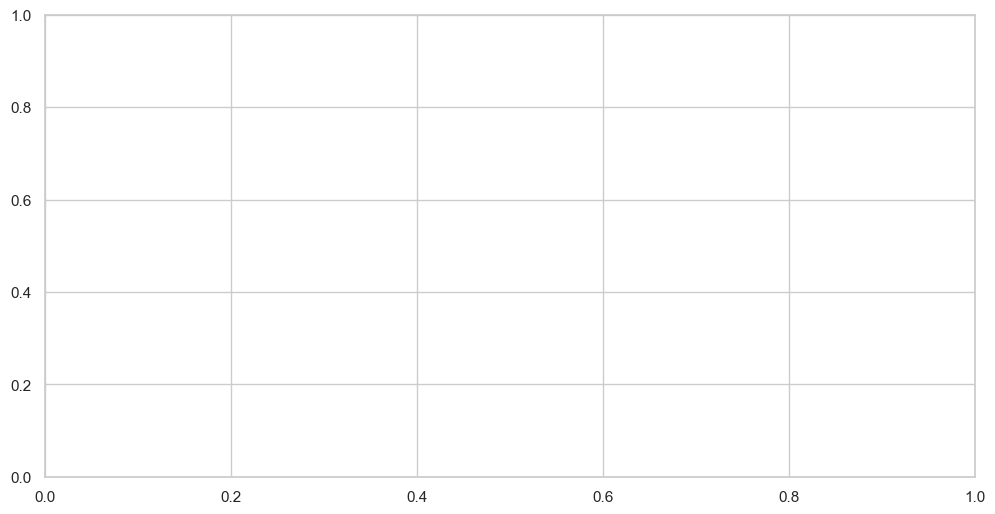

In [62]:
fig, ax = plt.subplots(figsize=(12, 6))

for i, row in df.iterrows():
    for j, value in enumerate(row):
        square_size = value ** 0.5  # Square root of the value
        ax.add_patch(plt.Rectangle((str(i), j - square_size / 2), 1, square_size, color='blue'))

ax.set_aspect('equal')
ax.set_xticks(range(len(df.index)))
ax.set_xticklabels(df.index)
ax.set_xlabel('Year')
ax.set_ylabel('Fuel Type')
ax.set_title('Number of Cars (Square Size Corresponds to Cars)')

plt.show()

In [22]:
data_switzerland_ind = data[(data["Canton"] == "Switzerland") & (data["Vehicle group / type"] == "> Passenger cars")]

plt.figure(figsize=(20,5))
sns.lineplot(data=data_switzerland_ind, x="time", y="value_watt", hue="season")

plt.xlabel("Time")
plt.ylabel("Consumption (Watt)")
plt.title("Consumption on average in a day per season for one household")


plt.show()

,Canton,Vehicle group / type,Fuel,1990,1991,1992,1993,1994,1995,1996,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Switzerland,> Passenger cars,Petrol,2905762,2975154,3006666,3022762,3073062,3132238,3166299,...,3234560,3201710,3173806,3149902,3127023,3114726,3099442,3087390,3054773,2991092
1,Switzerland,> Passenger cars,Diesel,79129,81883,83640,85703,90747,95585,100412,...,1035843,1123676,1214075,1291500,1346938,1374246,1382645,1379077,1360111,1319337
2,Switzerland,> Passenger cars,Electricity,409,671,771,774,775,770,759,...,2683,4439,7531,10724,14539,19181,28716,43396,71697,110751
3,Switzerland,> Passenger cars,Other,97,90,151,284,458,583,623,...,47799,54665,62657,71903,82323,94535,113149,148472,222785,300100
4,Switzerland,> Passenger cars,Without motor,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Model the distibution of charging start time over a day 

## Model the constraints of user and from charging 

## Model the overall load of EVs on the grid 

## Model the potential for flexibility

## Visualize the flexibility over time and for different scenarios